In [108]:
import os
from pathlib import Path
import re
import random
from sklearn.model_selection import KFold
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [68]:
# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, masks, transform=None):
        self.image_paths = image_paths
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        #_, file_base_name = os.path.split(img_path)
        file_base_name = os.path.split(img_path)[1].split(".")[0]
        data, frame, camera = self.__get_mask_info__(file_base_name)
        
        print(data, frame, camera)
        
        mask_human, mask_robot = self.__organize_masks__(self.masks, data, camera, frame)
        
        
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
    
    def __get_mask_info__(cls, strx):
        sub, act, rout, frame, camera = strx.split("_")
        return f"{sub}_{act}_{rout}", frame, camera
    
    @classmethod
    def __draw_contours__(cls, contours):
        # Criar uma imagem binária inicializada com valores 1 (branco)
        imagem_binaria = np.zeros((256, 256), dtype=np.uint8)

        # Converter os contornos para o formato aceito pelo OpenCV
        contornos_np = np.array(contours, dtype=np.int32)

        # Desenhar os contornos na imagem binária
        return cv2.drawContours(imagem_binaria, contornos_np, -1, (255, 255, 255), thickness=cv2.FILLED)
     
    def __organize_masks__(self, dataset_masks, data, camera, frame):
        
        dict_human = dataset_masks[f'{data}']
        dict_robot = dataset_masks[f'{data}_robot']
        
        for _, all_masks_found in dict_human.items():
            masks_data_camera = all_masks_found[f'subimage_{camera}']
            print(len(masks_data_camera))
            contours_human = masks_data_camera[frame]
        
        for _, all_masks_found in dict_robot.items():
            masks_data_camera = all_masks_found[f'subimage_{camera}']
            print(len(masks_data_camera))
            contours_robot = masks_data_camera[frame]
        
        return self.__draw_contours__(contours_human), self.__draw_contours__(contours_robot)
    
    
def extrair_numero_regex(texto):
    padrao = r'\d+'
    numeros = re.findall(padrao, texto)
    if numeros:
        return numeros[0]
    else:
        return None

def process_json_namefile(strx):

    splited = strx.split("_")
    formated = f"{int(extrair_numero_regex(splited[0]))}_{int(extrair_numero_regex(splited[1]))}_{int(extrair_numero_regex(splited[2]))}"

    if "robot" in strx:
        formated += "_robot"
        
    return formated



    
    
def load_dataset_masks(pasta):
    # Inicializa o dicionário para armazenar os dados
    dados_json = {}

    # Lista todos os arquivos na pasta
    arquivos = os.listdir(pasta)

    # Filtra apenas os arquivos JSON
    arquivos_json = [arquivo for arquivo in arquivos if arquivo.endswith('.json')]

    # Processa cada arquivo JSON encontrado
    for arquivo_json in tqdm(arquivos_json):
        caminho_completo = os.path.join(pasta, arquivo_json)
        nome_arquivo = os.path.basename(arquivo_json)

        # Carrega o conteúdo do arquivo JSON como um dicionário
        with open(caminho_completo, 'r', encoding='utf-8') as f:
            conteudo = json.load(f)
        
        # Adiciona ao dicionário final usando o nome do arquivo como chave
        dados_json[process_json_namefile(nome_arquivo)] = conteudo
    
    return dados_json

def load_image_paths(directory):
    """Loads all image paths from the specified directory."""
    path = Path(directory)
    image_paths = list(path.glob('*.jpg'))
    return [str(img) for img in image_paths]

def group_images_by_prefix(image_paths):
    """Groups images by their prefix NUMSUBJECT_NUMACTIVITY_NUM_ROUTINE."""
    pattern = re.compile(r'(\d+)_(\d+)_(\d+)_\d+_\d+.jpg')
    grouped = {}
    for img_path in image_paths:
        match = pattern.search(os.path.basename(img_path))
        if match:
            prefix = f"{match.group(1)}_{match.group(2)}_{match.group(3)}"
            if prefix not in grouped:
                grouped[prefix] = []
            grouped[prefix].append(img_path)
    return list(grouped.values())

def create_dataloaders(image_groups, dataset_masks, n_splits=5, batch_size=32, transform=None):
    """Creates DataLoaders for cross-validation."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    dataloaders = []
    
    for train_index, val_index in kf.split(image_groups):
        train_images = [img for i in train_index for img in image_groups[i]]
        val_images = [img for i in val_index for img in image_groups[i]]
        
        train_dataset = CustomImageDataset(train_images, dataset_masks, transform)
        val_dataset = CustomImageDataset(val_images, dataset_masks, transform)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        dataloaders.append((train_loader, val_loader))
    
    return dataloaders



In [58]:
image_directory = "C:/Users/iagor/Documents/git/data-definer/out/"
mask_directory = "C:/Users/iagor/Documents/git/human-segmentation-sam/out/"
batch_size = 32
n_splits = 5
    
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])


In [64]:
dataset_masks = load_dataset_masks(mask_directory)

100%|██████████| 216/216 [00:08<00:00, 26.08it/s]


In [69]:
image_paths = load_image_paths(image_directory)
image_groups = group_images_by_prefix(image_paths)
dataloaders = create_dataloaders(image_groups, dataset_masks, n_splits, batch_size, transform)
    
for fold, (train_loader, val_loader) in enumerate(dataloaders):
    print(f"Fold {fold+1}")
    for images in train_loader:
        print(f"Train batch: {images.size()}")
    for images in val_loader:
        print(f"Validation batch: {images.size()}")


Fold 1
1_2_12 30 2
1_1_4 60 4
2_1_1 210 3
1_2_8 225 2
2_1_2 720 3
1_2_12 75 4
1_2_12 105 1
1_2_8 120 2
1_1_5 300 2
1_2_9 300 3
1_2_7 270 4
1_2_11 165 4
2_1_2 585 4
2_1_2 105 1
1_2_7 390 3
1_1_5 60 2
2_1_2 105 3
2_1_3 285 4
2_1_2 825 1
1_2_12 150 4
2_1_2 570 2
1_1_5 585 2
1_1_5 450 1
2_1_3 555 3
1_2_10 255 3
2_1_3 90 3
2_1_2 240 3
1_1_3 600 4
2_1_2 765 3
1_2_7 315 1
1_2_12 315 2
2_1_1 255 1
Train batch: torch.Size([32, 3, 256, 256])
1_1_3 420 3
1_1_4 255 4
1_1_4 615 3
2_1_3 615 4
2_1_2 450 4
2_1_1 300 4
1_2_10 75 1
1_2_11 15 3
1_1_4 105 4
1_1_5 465 4
1_2_8 30 4
1_2_11 105 1
2_1_3 225 1
1_1_5 240 4
2_1_3 570 2
2_1_5 195 1
2_1_5 255 4
2_1_3 405 2
2_1_1 60 3
2_1_1 15 3
2_1_2 660 2
2_1_3 360 2
1_2_9 150 4
1_2_7 30 2
2_1_3 405 1
1_1_5 195 1
1_1_3 240 1
2_1_2 345 2
1_2_7 225 2
2_1_1 270 2
2_1_2 600 1
1_1_5 480 1
Train batch: torch.Size([32, 3, 256, 256])
2_1_3 120 3
1_2_12 330 4
2_1_2 420 1
1_2_12 285 4
1_1_5 420 2
2_1_2 735 3
1_2_7 135 2
1_1_3 45 3
2_1_3 405 3
1_2_10 315 2
2_1_3 735 1
2_1_1 

KeyboardInterrupt: 

In [70]:
def shape_lista(lista):
    if isinstance(lista, list):
        return [len(lista)] + shape_lista(lista[0])
    else:
        return []

# Exemplo de uso:
lista_aninhada = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]
dimensoes = shape_lista(lista_aninhada)
print("Dimensões da lista aninhada:", dimensoes)

Dimensões da lista aninhada: [3, 3]


In [72]:

shape_lista(dataset_masks['1_2_12'])

[]

In [127]:
def draw_contours(contours):
    # Criar uma imagem binária inicializada com valores 1 (branco)
    imagem_binaria = np.zeros((256, 256), dtype=np.uint8)

    # Converter os contornos para o formato aceito pelo OpenCV
    contornos_np = np.array(contours, dtype=np.int32)

    # Desenhar os contornos na imagem binária
    return cv2.drawContours(imagem_binaria, contornos_np, -1, (255, 255, 255), thickness=cv2.FILLED)
    

def organize_masks(dataset_masks, data, camera, frame):
    
    dict_human = dataset_masks[f'{data}']
    dict_robot = dataset_masks[f'{data}_robot']
    
    for _, all_masks_found in dict_human.items():
        masks_data_camera = all_masks_found[f'subimage_{camera}']
        print(len(masks_data_camera))
        contours_human = masks_data_camera[frame]
    
    for _, all_masks_found in dict_robot.items():
        masks_data_camera = all_masks_found[f'subimage_{camera}']
        print(len(masks_data_camera))
        contours_robot = masks_data_camera[frame]
    
    return draw_contours(contours_human), draw_contours(contours_robot)
    

data, frame, camera = "1_1_2", 90, 1

mask_human, mask_robot = organize_masks(dataset_masks, data, camera, frame)

99
99


In [121]:
mask_robot.shape

(256, 256)

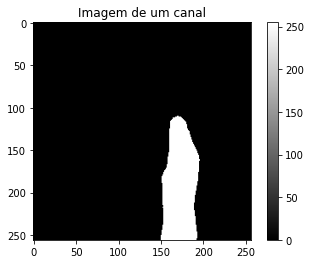

In [128]:
plt.imshow(mask_human, cmap='gray')  # cmap='gray' garante que a imagem será mostrada em tons de cinza
plt.title('Imagem de um canal')
plt.colorbar()  # Adiciona uma barra de cores para referência
plt.show()